In [74]:
import pickle as pkl
import pandas as pd
from tqdm import tqdm
import anndata as ad
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


In [2]:
ROOT = 'C:\\Users\\curea\\Documents\\bioFM for drug discovery\\dege-fm\\'
with open(ROOT + "results\\baseline_predictions.pkl", 'rb') as f:
    output_model = pkl.load(f)

In [5]:
output_model[0]['meta']

{'compound': ['Panobinostat (LBH589)',
  'AG-490 (Tyrphostin B42)',
  'Raltitrexed',
  'Ruxolitinib (INCB018424)',
  'Daphnetin',
  'Mesna ',
  'Altretamine',
  'Iniparib (BSI-201)',
  'Altretamine',
  'Tie2 kinase inhibitor',
  'AG-14361',
  'Trichostatin A (TSA)',
  'Mesna ',
  'M344',
  'PF-3845',
  'Mocetinostat (MGCD0103)',
  'Panobinostat (LBH589)',
  'ENMD-2076 L-(+)-Tartaric acid ',
  'Entinostat (MS-275)',
  'RG108',
  'Panobinostat (LBH589)',
  'BMS-265246',
  'S3I-201',
  'Tanespimycin (17-AAG)',
  'ABT-737',
  'ABT-737',
  'Entinostat (MS-275)',
  'Streptozotocin (STZ)',
  'ABT-737',
  'Andarine',
  'Tanespimycin (17-AAG)',
  'Sodium Phenylbutyrate',
  'Tanespimycin (17-AAG)',
  'BMS-265246',
  'Motesanib Diphosphate (AMG-706)',
  'AR-42',
  'M344',
  'Panobinostat (LBH589)',
  'Tucidinostat (Chidamide)',
  'Entinostat (MS-275)',
  'Ruxolitinib (INCB018424)',
  'M344',
  'Tie2 kinase inhibitor',
  'UNC0379',
  'Mesna ',
  'Epothilone A',
  'Streptozotocin (STZ)',
  'Triamci

In [6]:
targets = list()
predicted = list()
input = list()
meta = list()

for x in tqdm(output_model):

    assert x['targets'].shape == x['predicted'].shape

    for i in range(x['targets'].shape[0]):
        targets.append(x['targets'][i].cpu().numpy())

    for i in range(x['predicted'].shape[0]):
        predicted.append(x['predicted'][i].cpu().numpy())

    for i in range(x['input'].shape[0]):
        input.append(x['input'][i].cpu().numpy()[:1280])

    compound_list = x['meta']['compound']
    dose_list = x['meta']['dose'].tolist()
    cell_type = x['meta']['cell_type']

    for i in range(len(compound_list)):
        meta.append(compound_list[i] + "_" + str(dose_list[i]) + "_" + cell_type[i])


df_targets = pd.DataFrame(targets)
df_predicted = pd.DataFrame(predicted)
df_input = pd.DataFrame(input)

df_targets['data_type'] = "target"
df_predicted['data_type'] = "predicted"
df_input['data_type'] = "input"

df_targets['condition'] = meta
df_predicted['condition'] = meta
df_input['condition'] = meta

del meta

df = pd.concat([df_targets, df_predicted, df_input], axis=0, ignore_index=True)

del df_targets
del df_predicted
del df_input

X = df.iloc[:, :1280].values
obs = df[['condition', 'data_type']]

del df

adata = ad.AnnData(X=X, obs=obs)

del X
del obs

adata.write_h5ad(ROOT + "results\\adata_baseline_predictions.h5ad")



100%|██████████| 2554/2554 [00:18<00:00, 136.15it/s]
C:\Users\curea\anaconda3\envs\stable_diffusion\Lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [68]:
def plot_css(adata):
    """
    Compare r-squared values between the null model and predictions
        ** compare r-squared between control-target and predicted-target pairs **
    TODO: this assumes that the order of pairs is preserved
    """
    css_model = list()
    css_null = list()


    for condition in tqdm(list(adata.obs['condition'].unique())):
        adata_subset = adata[adata.obs['condition'] == condition]

        X_control = adata_subset[adata_subset.obs['data_type'] == "input"].X
        X_target = adata_subset[adata_subset.obs['data_type'] == "target"].X
        X_predicted = adata_subset[adata_subset.obs['data_type'] == "predicted"].X


        for i in range(X_control.shape[0]):
            x_control = X_control[i,]
            x_target = X_target[i,]
            x_predicted = X_predicted[i,]


            cosine_similarity_model = np.dot(x_target, x_predicted) / (np.linalg.norm(x_target) * np.linalg.norm(x_predicted))

            cosine_similarity_null = np.dot(x_target, x_control) / (np.linalg.norm(x_target) * np.linalg.norm(x_control))

            css_model.append(cosine_similarity_model)
            css_null.append(cosine_similarity_null)

    data = pd.DataFrame({
        "css": css_model + css_null,
        "model": ["model"] * len(css_model) + ["null"] * len(css_null)
    })

    plt.figure(figsize=(8, 6))  # Set the figure size
    sns.boxplot(x='model', y='css', data=data)  # Create the boxplot
    plt.xlabel('Predictor')  # X-axis label
    plt.ylabel('CSS')  # Y-axis label
    plt.show()  # Show the plot



100%|██████████| 660/660 [00:17<00:00, 36.81it/s]


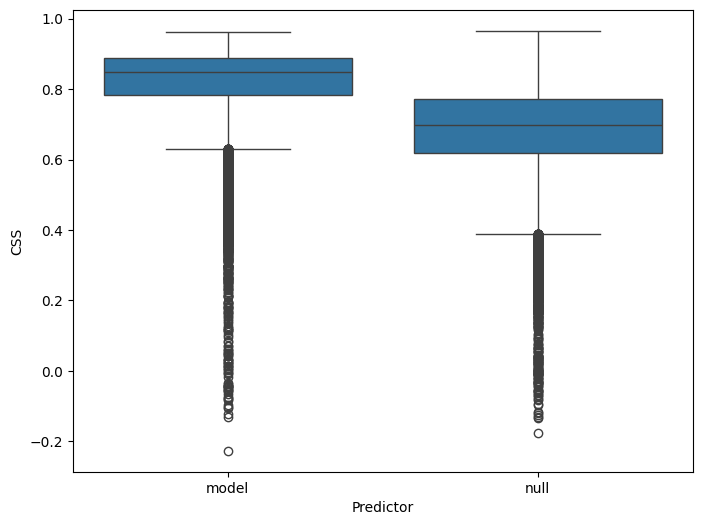

In [69]:
plot_css(adata)

In [70]:
def plot_mse(adata):
    """
    Compare r-squared values between the null model and predictions
        ** compare r-squared between control-target and predicted-target pairs **
    TODO: this assumes that the order of pairs is preserved
    """
    mse_model_list = list()
    mse_null_list = list()


    for condition in tqdm(list(adata.obs['condition'].unique())):
        adata_subset = adata[adata.obs['condition'] == condition]

        X_control = adata_subset[adata_subset.obs['data_type'] == "input"].X
        X_target = adata_subset[adata_subset.obs['data_type'] == "target"].X
        X_predicted = adata_subset[adata_subset.obs['data_type'] == "predicted"].X


        for i in range(X_control.shape[0]):
            x_control = X_control[i,]
            x_target = X_target[i,]
            x_predicted = X_predicted[i,]


            mse_model = np.mean((x_target - x_predicted) ** 2)

            mse_null = np.mean((x_target - x_control) ** 2)

            mse_model_list.append(mse_model)
            mse_null_list.append(mse_null)

    data = pd.DataFrame({
        "mse": mse_model_list + mse_null_list,
        "model": ["model"] * len(mse_model_list) + ["null"] * len(mse_null_list)
    })

    plt.figure(figsize=(8, 6))  # Set the figure size
    sns.boxplot(x='model', y='mse', data=data)  # Create the boxplot
    plt.xlabel('Predictor')  # X-axis label
    plt.ylabel('MSE')  # Y-axis label
    plt.show()  # Show the plot



100%|██████████| 660/660 [00:15<00:00, 42.00it/s]


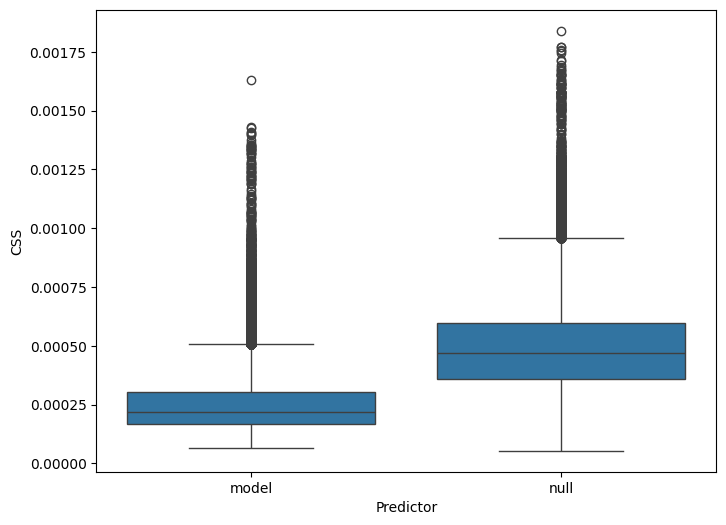

In [71]:
plot_mse(adata)